In [1]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline
import os

from pclib.nn.models import FCClassifierUs, FCClassifierUsMem
from pclib.optim.train import train
from pclib.optim.eval import track_vfe, accuracy
from pclib.utils.functional import identity, shrinkage
from pclib.utils.customdataset import PreloadedDataset

In [2]:
seed = 42
# For reproducibility
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
torch.manual_seed(seed)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),                                
    transforms.Normalize((0.1307,), (0.3081,)),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

dataset = datasets.MNIST('../Datasets/', train=True, download=False, transform=transforms.ToTensor())

VAL_RATIO = 0.2
val_len = int(len(dataset) * VAL_RATIO)
train_len = len(dataset) - val_len
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])
train_dataset = PreloadedDataset.from_dataset(train_dataset, train_transform, device)
val_dataset = PreloadedDataset.from_dataset(val_dataset, val_transform, device)

INPUT_SHAPE = 784
NUM_CLASSES = 10

  0%|          | 0/48000 [00:00<?, ?it/s]

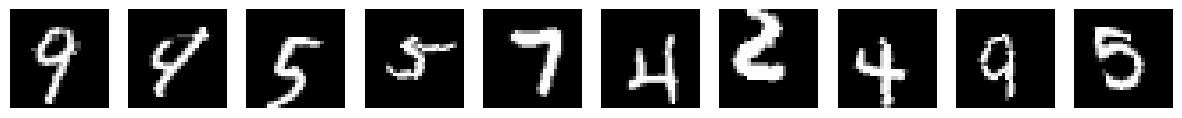

Max value:  tensor(2.8215, device='cuda:0')
Min value:  tensor(-0.4242, device='cuda:0')


In [4]:
train_dataset.apply_transform()
# Show some images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
idxs = torch.randperm(len(train_dataset))[:10]
for i, ax in enumerate(axes):
    img, label = train_dataset[idxs[i]]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.show()

# print max min values
print('Max value: ', train_dataset.transformed_images.max())
print('Min value: ', train_dataset.transformed_images.min())

In [9]:
torch.manual_seed(seed+2)

model_name = 'relu_sparse0.1_weightnorm-3'
model = FCClassifierUs(
    in_features=INPUT_SHAPE, 
    num_classes=NUM_CLASSES, 
    hidden_sizes=[600, 600],
    bias=True, 
    symmetric=True, 
    actv_fn=F.relu,
    steps=20,
    gamma=0.2,
    temp_k=0.0
    ).to(device)

In [10]:
# Train Loop
BATCH_SIZE = 200

log_dir = f'examples/mnist/out/logs/fc/unsup/{model_name}'

train(
    model, 
    train_dataset, 
    val_dataset, 
    num_epochs=100,
    lr=0.0001,
    c_lr=0,
    batch_size=BATCH_SIZE,
    reg_coeff=0.0,
    optim='AdamW',
    log_dir=log_dir,
    norm_weights=True,
    # scheduler='ReduceLROnPlateau',
)

train(
    model, 
    train_dataset, 
    val_dataset, 
    num_epochs=100, 
    lr=0.0,
    c_lr=0.001,
    batch_size=BATCH_SIZE,
    reg_coeff=0.02,
    optim='AdamW',
    log_dir=log_dir,
    scheduler='ReduceLROnPlateau',
)

Epoch 00057: reducing learning rate of group 0 to 1.0000e-04.


Epoch 00079: reducing learning rate of group 0 to 1.0000e-05.


Epoch 00099: reducing learning rate of group 0 to 1.0000e-06.


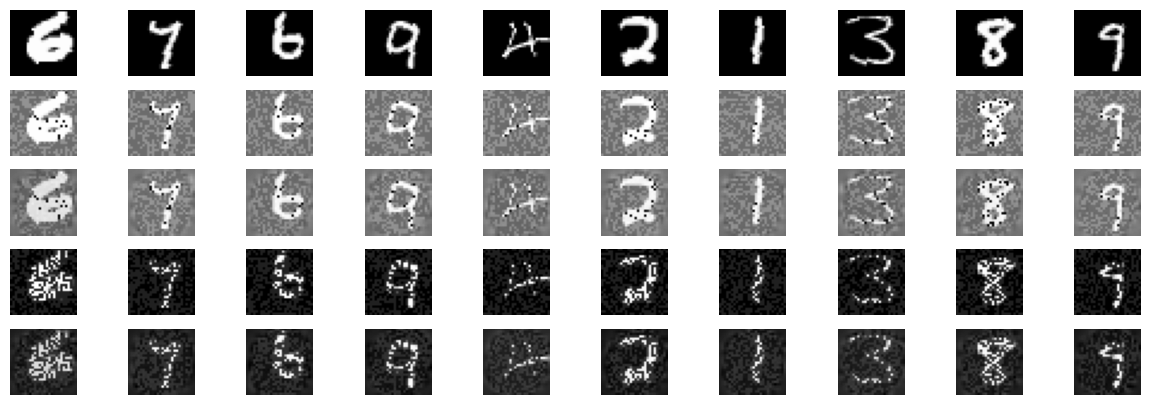

In [13]:
X = train_dataset.transformed_images
X_noisy = X + torch.randn_like(X) * 2.0
X_noisy = F.normalize(X_noisy, dim=1) * X.norm(dim=1, keepdim=True)
X_noisy_recon = model.reconstruct(X_noisy.to(device).flatten(1))[0].view(-1, 1, 28, 28).cpu()
X_partial = X * (torch.rand_like(X) < 0.5).float()
X_partial_recon = model.reconstruct(X_partial.to(device).flatten(1))[0].view(-1, 1, 28, 28).cpu()

# Show all 10 images, raw, noised and reconstructed
fig, axes = plt.subplots(5, 10, figsize=(15, 5))
for i, ax in enumerate(axes[0]):
    ax.imshow(X[i].squeeze().cpu(), cmap='gray')
    ax.axis('off')
for i, ax in enumerate(axes[1]):
    ax.imshow(X_noisy[i].squeeze().cpu(), cmap='gray')
    ax.axis('off')
for i, ax in enumerate(axes[2]):
    ax.imshow(X_noisy_recon[i].squeeze().cpu(), cmap='gray')
    ax.axis('off')
for i, ax in enumerate(axes[3]):
    ax.imshow(X_partial[i].squeeze().cpu(), cmap='gray')
    ax.axis('off')
for i, ax in enumerate(axes[4]):
    ax.imshow(X_partial_recon[i].squeeze().cpu(), cmap='gray')
    ax.axis('off')


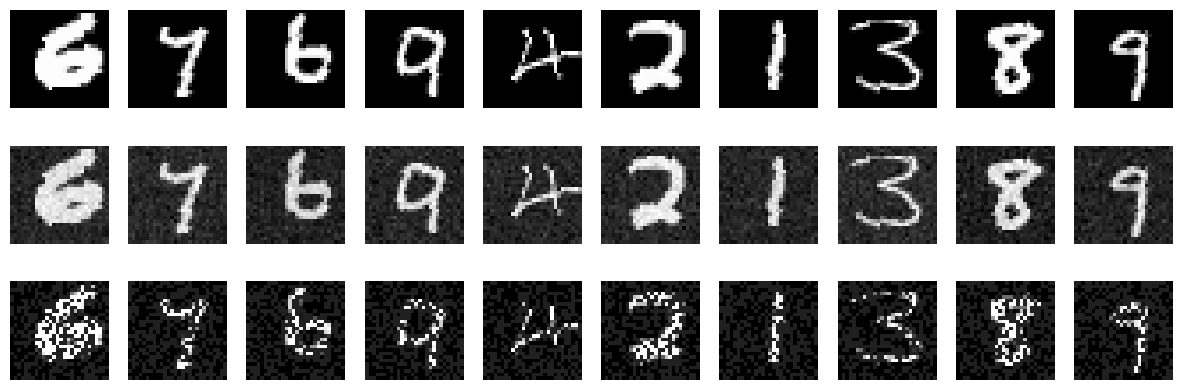

In [18]:
# get 10 images
images = []
noisy_images = []
partial_images = []
labels = []
for i in range(10):
    img, _ = train_dataset[i]
    images.append(img)
    noisy_images.append(img + torch.randn_like(img) * 0.2)
    partial_images.append(img * (torch.rand_like(img) < 0.5))
    labels.append(label)

# show images
fig, axes = plt.subplots(3, 10, figsize=(15, 5))
for i, ax in enumerate(axes[0]):
    ax.imshow(images[i].squeeze().cpu(), cmap='gray')
    ax.axis('off')
for i, ax in enumerate(axes[1]):
    ax.imshow(noisy_images[i].squeeze().cpu(), cmap='gray')
    ax.axis('off')
for i, ax in enumerate(axes[2]):
    ax.imshow(partial_images[i].squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.show()

images = torch.stack(images).flatten(1)
noisy_images = torch.stack(noisy_images).flatten(1)
partial_images = torch.stack(partial_images).flatten(1)

torch.Size([10, 784])


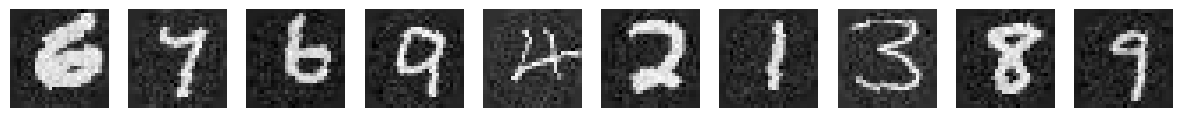

In [19]:
# reconstruct noisy images
out, state = model.reconstruct(noisy_images)
print(out.shape)


# show reconstructed images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(out[i].cpu().reshape(28, 28), cmap='gray')
    ax.axis('off')

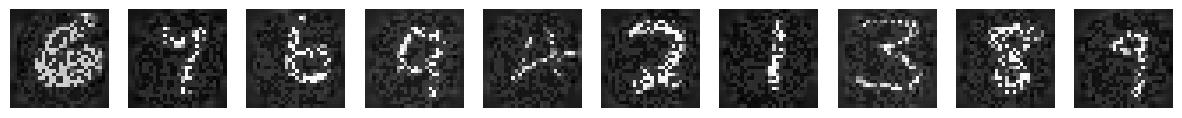

In [17]:
# reconstruct partial images
out, state = model.reconstruct(partial_images)

# show reconstructed images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(out[i].cpu().reshape(28, 28), cmap='gray')
    ax.axis('off')

In [14]:
# Current Accuracy and Error Rate
acc = accuracy(model, val_dataset, steps=0)
error = 100 * (1 - acc)
print(f'Current Val Acc: {acc} | error_rate: {error:0.2f} %')

Current Val Acc: 0.25275 | error_rate: 74.72 %


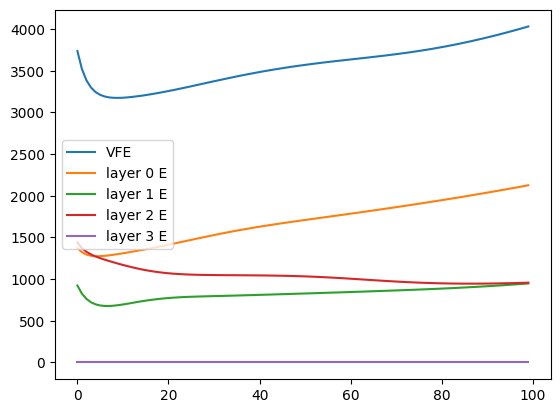

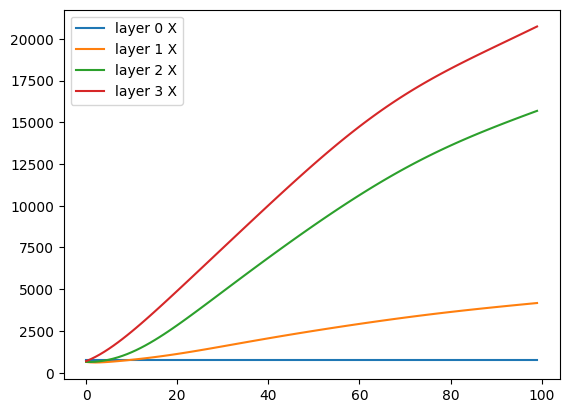

Layer 0 e_min, e_max, x_min, x_max: 789.656, 789.656, 1274.530, 2125.760
Layer 1 e_min, e_max, x_min, x_max: 612.253, 4173.938, 677.809, 947.602
Layer 2 e_min, e_max, x_min, x_max: 643.286, 15684.948, 945.730, 1438.842
Layer 3 e_min, e_max, x_min, x_max: 693.373, 20739.857, 0.000, 0.000


In [15]:
from pclib.utils.functional import format_y
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)
images, y = next(iter(train_loader))
x = images.view(images.shape[0], -1)
y = format_y(y, 10)
vfes, X, E = track_vfe(model, x=x, steps=100, plot_Es=True, plot_Xs=True)
for i in range(len(model.layers)):
    print(f'Layer {i} e_min, e_max, x_min, x_max: {min(E[i]):.3f}, {max(E[i]):.3f}, {min(X[i]):.3f}, {max(X[i]):.3f}')